In [1]:
from iris import time, cube
import cis
from cis import read_data, read_data_list, get_variables, data_io
from cis.data_io import gridded_data
from cis.data_io.gridded_data import make_from_cube
from cis.time_util import PartialDateTime
from cis import plotting
from cis.plotting import plot
from cis.plotting.plot import drawbluemarble, multilayer_plot, taylor_plot

import os
from datetime import datetime
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import copy
from flight_py_tools import FAAM

from dateutil.relativedelta import relativedelta
import numpy as np
import numpy.ma as ma
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)


In [2]:
# Directory containing raw aircraft data and names of variables to plot
inputdir1='/scratch/am2688/netscratch_all/mrr32/Flight_work/Flights/'
varname1='O3_TECO' ; source1='FAAM' ; variable1='Ozone' ; units1='(ppbv)'
# Position of date characters in the filename string
# Plugin to be used by cis.read_data
aircraft_plugin='FAAM'
# Directory containing model data on flight track and names of variables to plot
inputdir2='/scratch/am2688/netscratch_all/mrr32/Flight_work/Outdir/'
inputdir3='/scratch/am2688/netscratch_all/mrr32/Flight_work/Outdir_75/'
inputdir4='/scratch/am2688/netscratch_all/mrr32/Flight_work/Outdir_50/'
inputdir5='/scratch/am2688/netscratch_all/mrr32/Flight_work/Outdir_25/'

varname2='m01s51i001' ; source2='UKCA' ; variable2='Ozone' ; units2='(ppbv)'
stash='51001' ; cfactor=1.e9/1.657
# Directory to store plots
outdir='/home/am2688/nethome/Plots/'
# colors for colorbars (from https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3):
# Diverging: blue to red (9 colours)
blue_to_red =['#313695','#4575b4','#74add1','#abd9e9','#ffffff','#fdae61','#f46d43','#d73027','#a50026'] 
# Diverging: green to magenta (9 colours)
green_to_magenta = ['#276419','#4d9221','#7fbc41','#b8e186','#ffffff','#f1b6da','#de77ae','#c51b7d','#8e0152']
# Sequential: yellow to red (7 colours)
yellow_to_red = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
my_colours= ['#a6cee3','#1f78b4','#b2df8a','#33a02c'] #colourblind+qualitative safe, but included greens
final_colours= ['#ca0020','#f4a582','#92c5de','#0571b0'] #colourblind safe + diverging
colour_100='#ca0020'
colour_75='#f4a582'
colour_50='#0571b0'
colour_25='#92c5de'

In [3]:
# Read all Obs
infile1=inputdir1+'*.nc'
obs=cis.read_data(infile1,varname1,product='FAAM')
# Read all Model data 100%
infile2=inputdir2+'*'+'stash'+stash+'*'
mod=cis.read_data(infile2,varname2,product='FAAM')
# Read all Model data 75%
infile3=inputdir3+'*'+'stash'+stash+'*'
mod_75=cis.read_data(infile3,varname2,product='FAAM')
# Read all Model data 50%
infile4=inputdir4+'*'+'stash'+stash+'*'
mod_50=cis.read_data(infile4,varname2,product='FAAM')
# Read all Model data 25%
infile5=inputdir5+'*'+'stash'+stash+'*'
mod_25=cis.read_data(infile5,varname2,product='FAAM')

In [4]:
# Extract np arrays from variables masked arrays
# This is necessary to avoid errors whilst operating on the variables
obs.data=ma.getdata(obs.data)
mod.data=ma.getdata(mod.data)
for cc in range(len(obs._coords)) :
    obs._coords[cc].data=ma.getdata(obs._coords[cc].data)
    mod._coords[cc].data=ma.getdata(mod._coords[cc].data)
    mod_75._coords[cc].data=ma.getdata(mod_75._coords[cc].data)
    mod_50._coords[cc].data=ma.getdata(mod_50._coords[cc].data)
    mod_25._coords[cc].data=ma.getdata(mod_25._coords[cc].data)

In [5]:
#remove negative and nans using masked arrays
obs.data=ma.masked_less_equal(obs.data, 3)
obs.data=ma.masked_invalid(obs.data)
#obs.data=ma.masked_greater_equal(obs.data, 90)
# Convert model data to ppbv
mod.data=mod.data*cfactor
mod_75.data=mod_75.data*cfactor
mod_50.data=mod_50.data*cfactor
mod_25.data=mod_25.data*cfactor

mod.data=ma.masked_invalid(mod.data)
mod_75.data=ma.masked_invalid(mod_75.data)
mod_50.data=ma.masked_invalid(mod_50.data)
mod_25.data=ma.masked_invalid(mod_25.data)

In [6]:
# Subset Model and Obs
# Tropical Upper Troposphere (TUT): 6-13km and 30S:30N
TUT_obs=obs.subset(z=[4000.,11000.],y=[-30.,30.])
TUT_mod=mod.subset(z=[4000.,11000.],y=[-30.,30.])
TUT_mod_75=mod_75.subset(z=[4000.,11000.],y=[-30.,30.])
TUT_mod_50=mod_50.subset(z=[4000.,11000.],y=[-30.,30.])
TUT_mod_25=mod_25.subset(z=[4000.,11000.],y=[-30.,30.])

# Mid-latitude Upper Troposphere/Lower Stratosphere: 6-13km and 30N:90N
UTLS_obs=obs.subset(z=[4000.,11000.],y=[30.,90.])
UTLS_mod=mod.subset(z=[4000.,11000.],y=[30.,90.])
UTLS_mod_75=mod_75.subset(z=[4000.,11000.],y=[30.,90.])
UTLS_mod_50=mod_50.subset(z=[4000.,11000.],y=[30.,90.])
UTLS_mod_25=mod_25.subset(z=[4000.,11000.],y=[30.,90.])


In [7]:

dec=2
TUT_obs_mean=np.around(np.ma.mean(TUT_obs.data), decimals=dec)
TUT_mod_mean=np.around(np.ma.mean(TUT_mod.data), decimals=dec)
TUT_mod_75_mean=np.around(np.ma.mean(TUT_mod_75.data), decimals=dec)
TUT_mod_50_mean=np.around(np.ma.mean(TUT_mod_50.data), decimals=dec)
TUT_mod_25_mean=np.around(np.ma.mean(TUT_mod_25.data), decimals=dec)

UTLS_obs_mean=np.around(np.ma.mean(UTLS_obs.data), decimals=dec)
UTLS_mod_mean=np.around(np.ma.mean(UTLS_mod.data), decimals=dec)
UTLS_mod_75_mean=np.around(np.ma.mean(UTLS_mod_75.data), decimals=dec)
UTLS_mod_50_mean=np.around(np.ma.mean(UTLS_mod_50.data), decimals=dec)
UTLS_mod_25_mean=np.around(np.ma.mean(UTLS_mod_25.data), decimals=dec)


In [8]:
mean_label= 'mean='
overlap_label= 'overlap='

0.7451152463505273


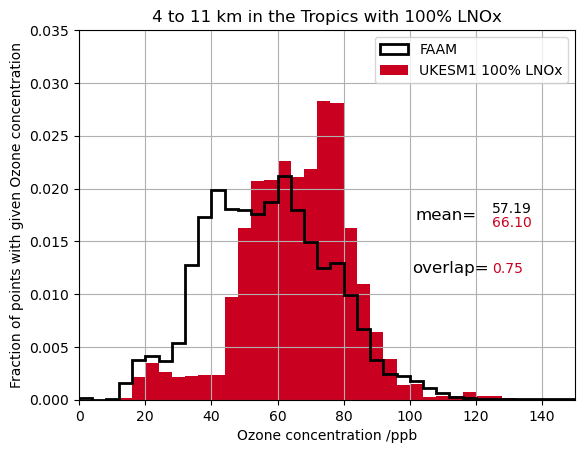

In [36]:
#TUT hist obs vs mod 100%

binsize = 4
binstart = 0
binend = 502

n1, bins, patches = plt.hist(TUT_obs.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor='black', linewidth=2, label="FAAM")
#n, bins, patches = plt.hist(TUT_mod.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor=colour_100, linewidth=4.5, label="UKESM1 100% LNOx")
n, bins, patches = plt.hist(TUT_mod.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, facecolor=colour_100, label="UKESM1 100% LNOx")

plt.xlabel('Ozone concentration /ppb')
plt.ylabel('Fraction of points with given Ozone concentration')
plt.title('4 to 11 km in the Tropics with 100% LNOx')
xlim = 150
plt.xlim(0, xlim)
plt.ylim(0,0.035)
plt.grid(True)
plt.legend(loc='upper right')
plt.figtext(0.77, 0.5, TUT_obs_mean, c='black') 
#plt.figtext(0.77, 0.47, TUT_mod_mean, c=colour_100)
plt.figtext(0.77, 0.47, '66.10', c=colour_100)

plt.figtext(0.65, 0.485, mean_label, c='black', fontsize=12)
plt.figtext(0.645, 0.375, overlap_label, c='black', fontsize=12)

frequency =np.array(n)
frequency1 =np.array(n1)
min_freq= np.minimum(frequency1,frequency)
print(sum(min_freq)/0.25)
skill_score=np.around(sum(min_freq)/sum(frequency), decimals=2)
#plt.figtext(0.77, 0.43, sum(min_freq)/0.25, c=colour_100)
plt.figtext(0.77, 0.375, skill_score, c=colour_100)
#plt.show()
plt.savefig(outdir+'overlap_4_11_tropics_100.png',dpi=300,bbox_inches='tight')
plt.show()

0.7897621066453928


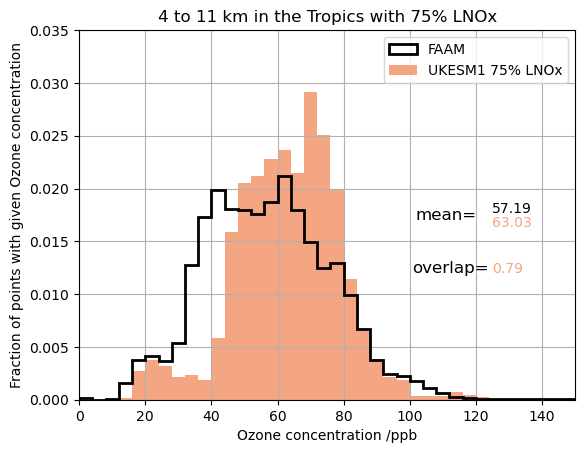

In [37]:
#310 hist obs vs mod 100%

binsize = 4
binstart = 0
binend = 502

n1, bins, patches = plt.hist(TUT_obs.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor='black', linewidth=2, label="FAAM")
#n, bins, patches = plt.hist(TUT_mod.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor=colour_100, linewidth=4.5, label="UKESM1 100% LNOx")
n, bins, patches = plt.hist(TUT_mod_75.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, facecolor=colour_75, label="UKESM1 75% LNOx")

plt.xlabel('Ozone concentration /ppb')
plt.ylabel('Fraction of points with given Ozone concentration')
plt.title('4 to 11 km in the Tropics with 75% LNOx')
xlim = 150
plt.xlim(0, xlim)
plt.ylim(0,0.035)
plt.grid(True)
plt.legend(loc='upper right')
plt.figtext(0.77, 0.5, TUT_obs_mean, c='black') 
plt.figtext(0.77, 0.47, TUT_mod_75_mean, c=colour_75) 

plt.figtext(0.65, 0.485, mean_label, c='black', fontsize=12)
plt.figtext(0.645, 0.375, overlap_label, c='black', fontsize=12)

frequency =np.array(n)
frequency1 =np.array(n1)
min_freq= np.minimum(frequency1,frequency)
print(sum(min_freq)/0.25)
skill_score=np.around(sum(min_freq)/sum(frequency), decimals=2)
plt.figtext(0.77, 0.375, skill_score, c=colour_75)

#plt.show()
plt.savefig(outdir+'overlap_4_11_tropics_75.png',dpi=300,bbox_inches='tight')
plt.show()

0.8009377407192353


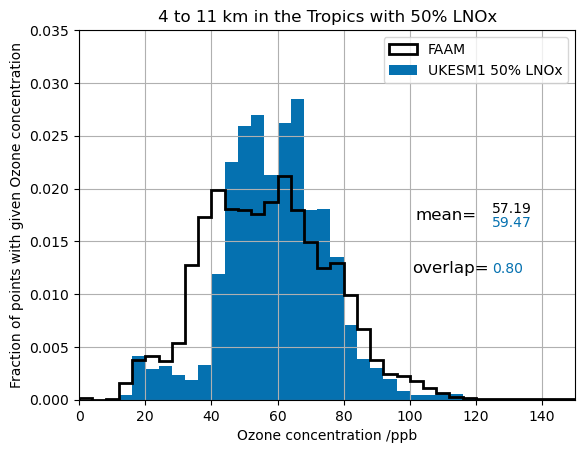

In [39]:
#310 hist obs vs mod 100%

binsize = 4
binstart = 0
binend = 502

n1, bins, patches = plt.hist(TUT_obs.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor='black', linewidth=2, label="FAAM")
#n, bins, patches = plt.hist(TUT_mod.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor=colour_100, linewidth=4.5, label="UKESM1 100% LNOx")
n, bins, patches = plt.hist(TUT_mod_50.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, facecolor=colour_50, label="UKESM1 50% LNOx")

plt.xlabel('Ozone concentration /ppb')
plt.ylabel('Fraction of points with given Ozone concentration')
plt.title('4 to 11 km in the Tropics with 50% LNOx')
xlim = 150
plt.xlim(0, xlim)
plt.ylim(0,0.035)
plt.grid(True)
plt.legend(loc='upper right')
plt.figtext(0.77, 0.5, TUT_obs_mean, c='black') 
plt.figtext(0.77, 0.47, TUT_mod_50_mean, c=colour_50) 

plt.figtext(0.65, 0.485, mean_label, c='black', fontsize=12)
plt.figtext(0.645, 0.375, overlap_label, c='black', fontsize=12)

frequency =np.array(n)
frequency1 =np.array(n1)
min_freq= np.minimum(frequency1,frequency)
print(sum(min_freq)/0.25)
skill_score=np.around(sum(min_freq)/sum(frequency), decimals=2)
#plt.figtext(0.77, 0.375, skill_score, c=colour_50)
plt.figtext(0.77, 0.375, '0.80', c=colour_50)

#plt.show()
plt.savefig(outdir+'overlap_4_11_tropics_50.png',dpi=300,bbox_inches='tight')
plt.show()

0.8032898776674811


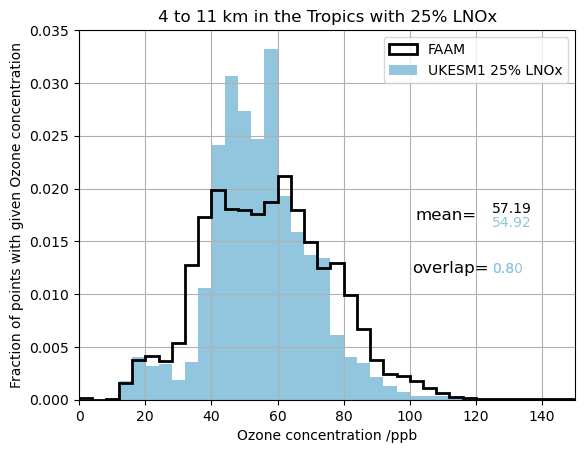

In [40]:
#310 hist obs vs mod 100%

binsize = 4
binstart = 0
binend = 502

n1, bins, patches = plt.hist(TUT_obs.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor='black', linewidth=2, label="FAAM")
#n, bins, patches = plt.hist(TUT_mod.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor=colour_100, linewidth=4.5, label="UKESM1 100% LNOx")
n, bins, patches = plt.hist(TUT_mod_25.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, facecolor=colour_25, label="UKESM1 25% LNOx")

plt.xlabel('Ozone concentration /ppb')
plt.ylabel('Fraction of points with given Ozone concentration')
plt.title('4 to 11 km in the Tropics with 25% LNOx')
xlim = 150
plt.xlim(0, xlim)
plt.ylim(0,0.035)
plt.grid(True)
plt.legend(loc='upper right')
plt.figtext(0.77, 0.5, TUT_obs_mean, c='black') 
plt.figtext(0.77, 0.47, TUT_mod_25_mean, c=colour_25) 

plt.figtext(0.65, 0.485, mean_label, c='black', fontsize=12)
plt.figtext(0.645, 0.375, overlap_label, c='black', fontsize=12)

frequency =np.array(n)
frequency1 =np.array(n1)
min_freq= np.minimum(frequency1,frequency)
print(sum(min_freq)/0.25)
skill_score=np.around(sum(min_freq)/sum(frequency), decimals=2)
plt.figtext(0.77, 0.375, skill_score, c=colour_25)
plt.figtext(0.77, 0.375, '0.80', c=colour_25)

#plt.show()
plt.savefig(outdir+'overlap_4_11_tropics_25.png',dpi=300,bbox_inches='tight')
plt.show()

0.7682725648670021


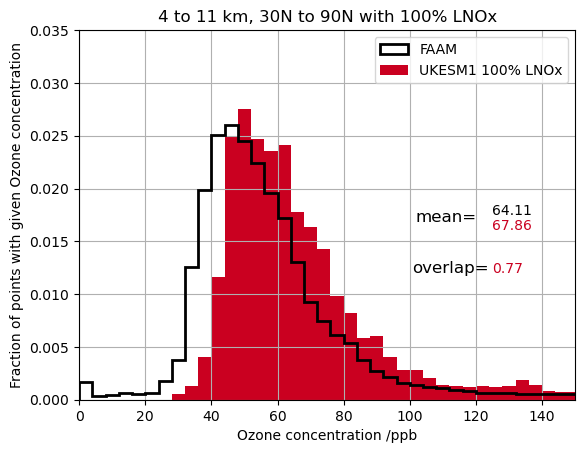

In [41]:
#310 hist obs vs mod 100%

binsize = 4
binstart = 0
binend = 502

n1, bins, patches = plt.hist(UTLS_obs.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor='black', linewidth=2, label="FAAM")
#n, bins, patches = plt.hist(UTLS_mod.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor=colour_100, linewidth=4.5, label="UKESM1 100% LNOx")
n, bins, patches = plt.hist(UTLS_mod.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, facecolor=colour_100, label="UKESM1 100% LNOx")

plt.xlabel('Ozone concentration /ppb')
plt.ylabel('Fraction of points with given Ozone concentration')
plt.title('4 to 11 km, 30N to 90N with 100% LNOx')
xlim = 150
plt.xlim(0, xlim)
plt.ylim(0, 0.035)
plt.grid(True)
plt.legend(loc='upper right')
plt.figtext(0.77, 0.495, UTLS_obs_mean, c='black') 
plt.figtext(0.77, 0.465, UTLS_mod_mean, c=colour_100) 

plt.figtext(0.65, 0.48, mean_label, c='black', fontsize=12)
plt.figtext(0.645, 0.375, overlap_label, c='black', fontsize=12)

frequency =np.array(n)
frequency1 =np.array(n1)
min_freq= np.minimum(frequency1,frequency)
print(sum(min_freq)/0.25)
skill_score=np.around(sum(min_freq)/sum(frequency), decimals=2)
plt.figtext(0.77, 0.375, skill_score, c=colour_100)

#plt.show()
plt.savefig(outdir+'overlap_4_11_extratropics_100.png',dpi=300,bbox_inches='tight')
plt.show()

0.7885194850908207


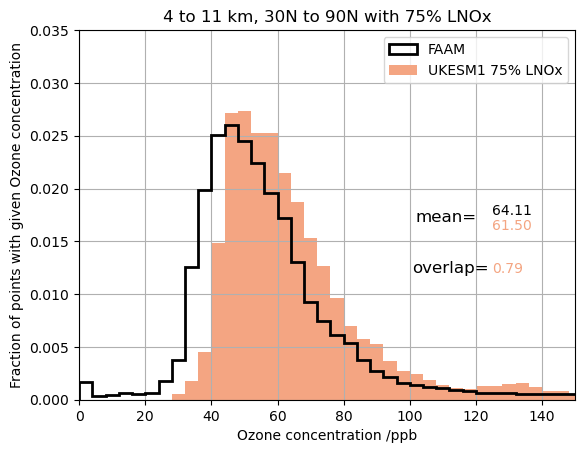

In [42]:
#310 hist obs vs mod 100%

binsize = 4
binstart = 0
binend = 502

n1, bins, patches = plt.hist(UTLS_obs.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor='black', linewidth=2, label="FAAM")
#n, bins, patches = plt.hist(UTLS_mod.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor=colour_100, linewidth=4.5, label="UKESM1 100% LNOx")
n, bins, patches = plt.hist(UTLS_mod_75.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, facecolor=colour_75, label="UKESM1 75% LNOx")

plt.xlabel('Ozone concentration /ppb')
plt.ylabel('Fraction of points with given Ozone concentration')
plt.title('4 to 11 km, 30N to 90N with 75% LNOx')
xlim = 150
plt.xlim(0, xlim)
plt.ylim(0, 0.035)
plt.grid(True)
plt.legend(loc='upper right')
plt.figtext(0.77, 0.495, UTLS_obs_mean, c='black') 
#plt.figtext(0.77, 0.465, UTLS_mod_75_mean, c=colour_75) 
plt.figtext(0.77, 0.465, '61.50', c=colour_75) 

plt.figtext(0.65, 0.48, mean_label, c='black', fontsize=12)
plt.figtext(0.645, 0.375, overlap_label, c='black', fontsize=12)

frequency =np.array(n)
frequency1 =np.array(n1)
min_freq= np.minimum(frequency1,frequency)
print(sum(min_freq)/0.25)
skill_score=np.around(sum(min_freq)/sum(frequency), decimals=2)
plt.figtext(0.77, 0.375, skill_score, c=colour_75)

#plt.show()
plt.savefig(outdir+'overlap_4_11_extratropics_75.png',dpi=300,bbox_inches='tight')
plt.show()

0.8130754598728361


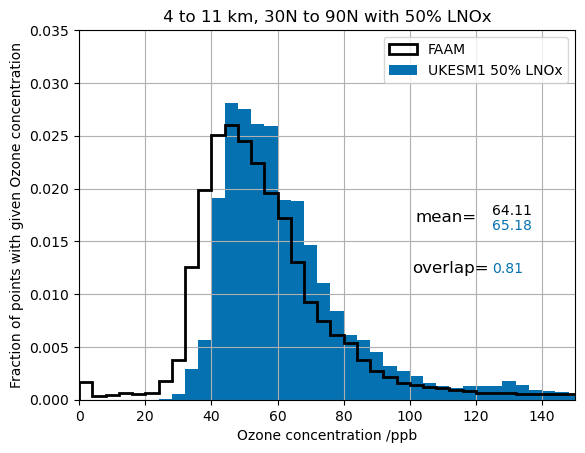

In [43]:
#310 hist obs vs mod 100%

binsize = 4
binstart = 0
binend = 502

n1, bins, patches = plt.hist(UTLS_obs.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor='black', linewidth=2, label="FAAM")
#n, bins, patches = plt.hist(UTLS_mod.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor=colour_100, linewidth=4.5, label="UKESM1 100% LNOx")
n, bins, patches = plt.hist(UTLS_mod_50.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, facecolor=colour_50, label="UKESM1 50% LNOx")

plt.xlabel('Ozone concentration /ppb')
plt.ylabel('Fraction of points with given Ozone concentration')
plt.title('4 to 11 km, 30N to 90N with 50% LNOx')
xlim = 150
plt.xlim(0, xlim)
plt.ylim(0, 0.035)
plt.grid(True)
plt.legend(loc='upper right')
plt.figtext(0.77, 0.495, UTLS_obs_mean, c='black') 
plt.figtext(0.77, 0.465, UTLS_mod_50_mean, c=colour_50) #doesn't dow second dp
#plt.figtext(0.77, 0.465, '70.90', c=colour_50) 

plt.figtext(0.65, 0.48, mean_label, c='black', fontsize=12)
plt.figtext(0.645, 0.375, overlap_label, c='black', fontsize=12)

frequency =np.array(n)
frequency1 =np.array(n1)
min_freq= np.minimum(frequency1,frequency)
print(sum(min_freq)/0.25)
skill_score=np.around(sum(min_freq)/sum(frequency), decimals=2)
plt.figtext(0.77, 0.375, skill_score, c=colour_50)


#plt.show()
plt.savefig(outdir+'overlap_4_11_extratropics_50.png',dpi=300,bbox_inches='tight')
plt.show()

0.8454430996198044


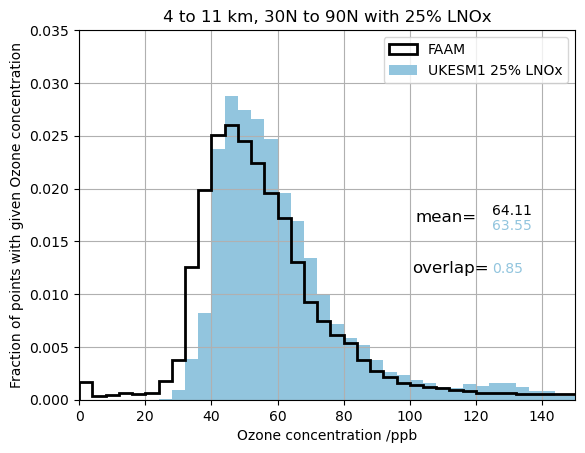

In [44]:
#310 hist obs vs mod 100%

binsize = 4
binstart = 0
binend = 502

n1, bins, patches = plt.hist(UTLS_obs.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor='black', linewidth=2, label="FAAM")
#n, bins, patches = plt.hist(UTLS_mod.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, histtype='step', facecolor='None',edgecolor=colour_100, linewidth=4.5, label="UKESM1 100% LNOx")
n, bins, patches = plt.hist(UTLS_mod_25.data, bins=np.arange(binstart, binend + binsize, binsize), density=True, facecolor=colour_25, label="UKESM1 25% LNOx")

plt.xlabel('Ozone concentration /ppb')
plt.ylabel('Fraction of points with given Ozone concentration')
plt.title('4 to 11 km, 30N to 90N with 25% LNOx')
xlim = 150
plt.xlim(0, xlim)
plt.ylim(0, 0.035)
plt.grid(True)
plt.legend(loc='upper right')
plt.figtext(0.77, 0.495, UTLS_obs_mean, c='black') 
plt.figtext(0.77, 0.465, UTLS_mod_25_mean, c=colour_25) 

plt.figtext(0.65, 0.48, mean_label, c='black', fontsize=12)
plt.figtext(0.645, 0.375, overlap_label, c='black', fontsize=12)

frequency =np.array(n)
frequency1 =np.array(n1)
min_freq= np.minimum(frequency1,frequency)
print(sum(min_freq)/0.25)
skill_score=np.around(sum(min_freq)/sum(frequency), decimals=2)
plt.figtext(0.77, 0.375, skill_score, c=colour_25)

#plt.show()
plt.savefig(outdir+'overlap_4_11_extratropics_25.png',dpi=300,bbox_inches='tight')
plt.show()